# PYMC tutorial

## Setup

**n.b. Installation with conda is broken for Mac as conda is not installing BLAS properly.**

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from scipy import stats

In [3]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Model Creation

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

In [5]:
model.basic_RVs

[mu ~ Normal(0, 1), obs ~ Normal(mu, 1)]

In [6]:
model.free_RVs

[mu ~ Normal(0, 1)]

In [7]:
model.observed_RVs

[obs ~ Normal(mu, 1)]

In [8]:
model.compile_logp()({"mu": 0})

array(-122.79890487)

## Distributions

### Unobserved random variables

In [9]:
with pm.Model():
    x = pm.Normal("x", mu = 0, tau = 1/3)

pm.logp(x, 3).eval()

array(-2.96824468)

### Observed random variables

In [10]:
with pm.Model():
    obs = pm.Normal("obs", mu = 0, tau = 1, observed=rng.standard_normal(100))

### Deterministic Transformations

In [11]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

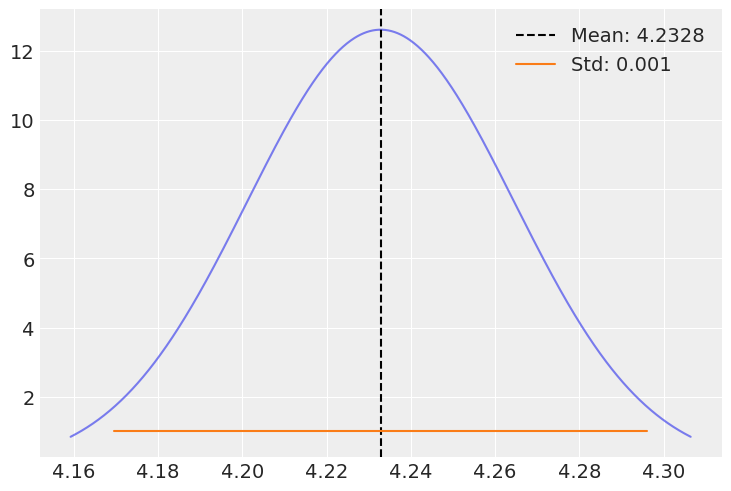

In [12]:
sigma = 1
sigma_0 = 6
mu_0 = 25
n = 1000
observations = np.random.normal(mu_0, sigma_0, n)

mean, std = [
    np.power((1/sigma_0) + (n/sigma), -1)*((mu_0/sigma_0) + (np.sum(observations)/sigma_0)),
    np.power((1/sigma_0) + (n/sigma), -1)
]

posterior = stats.norm(mean, np.sqrt(std))

x = np.linspace(posterior.ppf(0.01),
                posterior.ppf(0.99), 1000)
plt.plot(x, posterior.pdf(x), alpha=0.6)

plt.axvline(mean, c = 'black', linestyle = "--", label = f"Mean: {round(mean, 4)}")

plt.plot(np.linspace(mean-(2*abs(np.sqrt(std))), mean+(2*abs(np.sqrt(std))), 100), np.ones(100), label = f"Std: {round(std, 4)}")

plt.legend()


In [13]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = sigma)
    obs = pm.Normal("obs", mu = mu_0, sigma = sigma_0, observed = observations)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

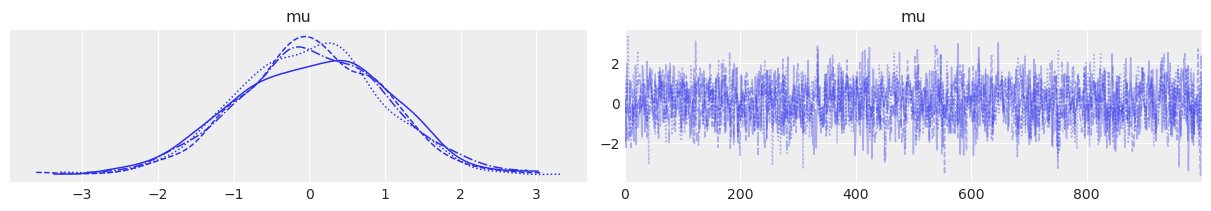

In [14]:
az.plot_trace(idata)

<Axes: title={'center': 'mu'}>

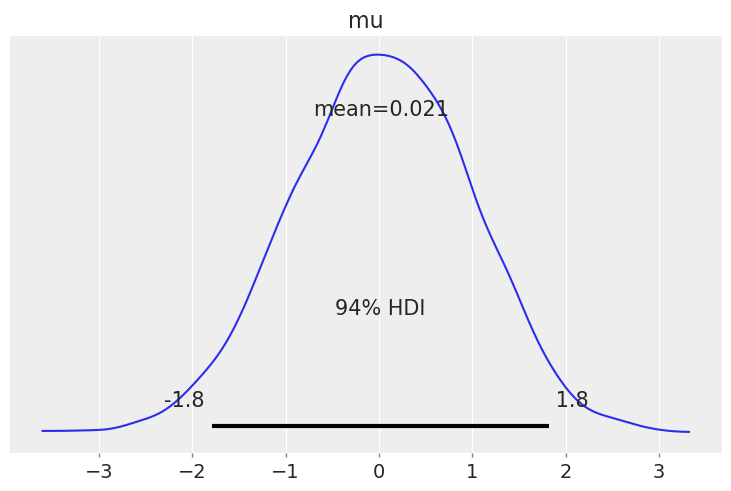

In [15]:
az.plot_posterior(idata)

In [16]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Motivating example: Linear Regression

In [17]:
# True parameter values
c,  = 1, 1
beta = 1

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)

# Simulate outcome variable
Y = alpha + beta * X1 + rng.normal(size=size) * sigma

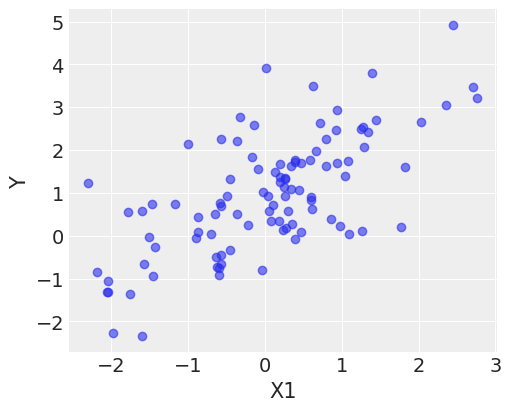

In [18]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5, 4))
axes.scatter(X1, Y, alpha=0.6)
axes.set_ylabel("Y")
axes.set_xlabel("X1");

In [26]:
lin_reg = pm.Model() # Creates a new model

with lin_reg:
    # Priors for unknown model parameters

    # Create stochastic random variables with normally-distributed prior distributions for the regression coefficients
    # with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of 
    # the observations. These are stochastic because their values are partly determined by their parents in the
    # dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).    

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=1)
    sigma = pm.HalfNormal("sigma", sigma = 1)

    # Expected value of outcome
    # Line specifes the relationship between expected value given the observation
    # This creates a deterministic random variable, which implies that its value is completely determined by 
    # its parents’ values.

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu = alpha + beta * X1, sigma=sigma, observed=Y)

In [27]:
with lin_reg:
    # draw 1000 posterior samples
    pymc_ols = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


0.9449162181398357 0.8321563885994685
<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    alpha    float64 8B 0.9452
    beta     float64 8B 0.8337
    sigma    float64 8B 1.021


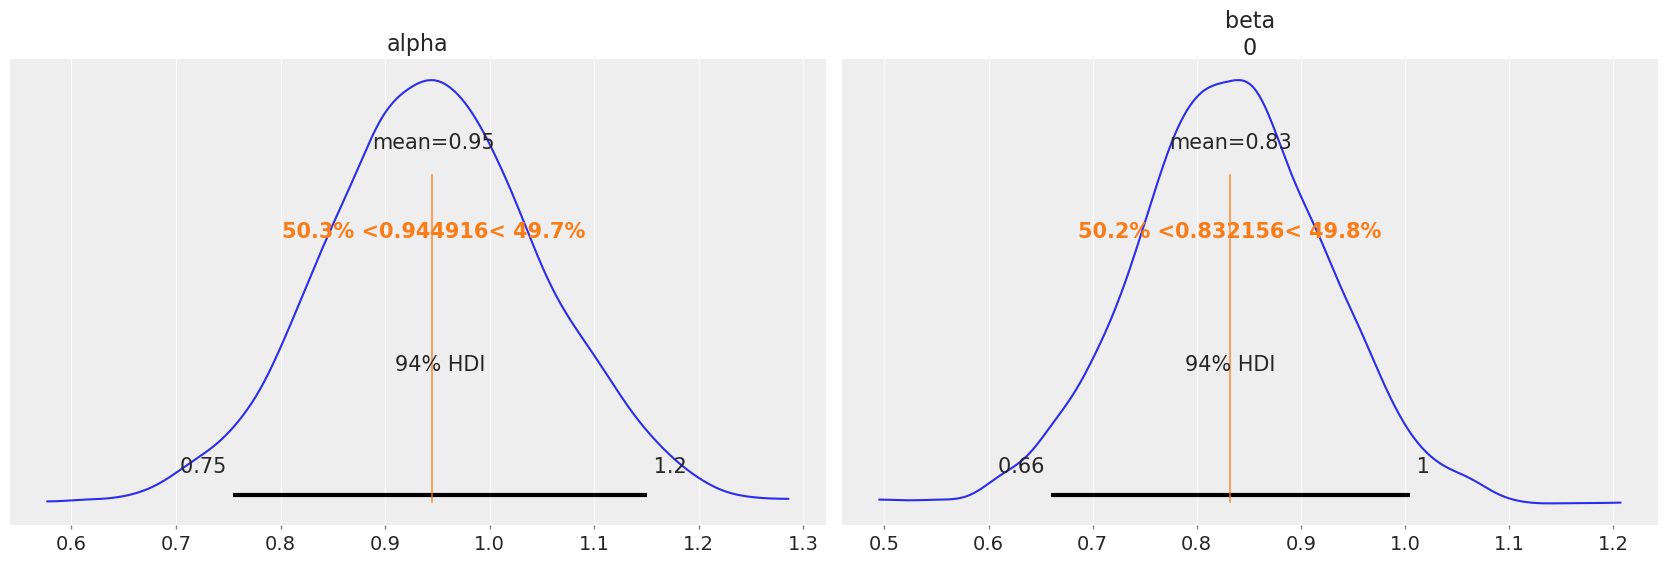

In [28]:
beta_r, alpha_r = np.polyfit(X1, Y, deg = 1)

print(alpha_r, beta_r)
print(idata.posterior.mean())

az.plot_posterior(pymc_ols, var_names = ["alpha", "beta"],
                  ref_val = [alpha_r, beta_r]);

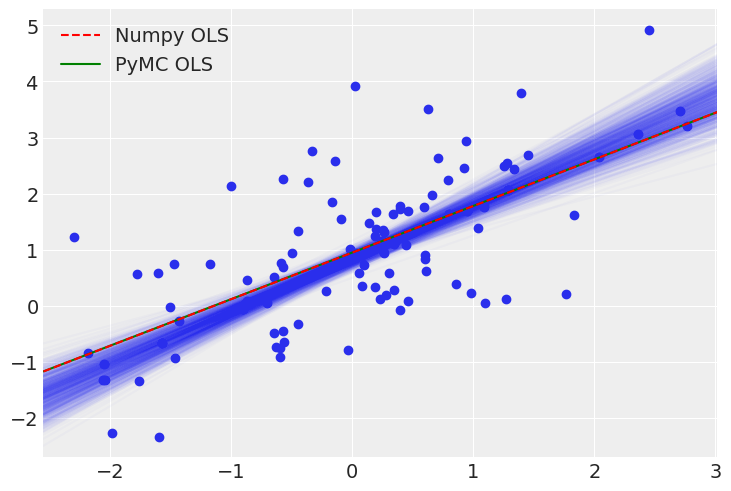

In [30]:
fig, ax = plt.subplots()

for m, b in zip(pymc_ols.posterior["alpha"].values.flat[::5], pymc_ols.posterior["beta"].values.flat[::5]):
    ax.axline((0, b), slope = m, alpha = 0.025, c = 'C0');

ax.scatter(X1, Y)

ax.axline(xy1 = (0, alpha_r), slope = beta_r, color = "r", ls = "--", zorder = 5, label = "Numpy OLS");

ax.axline((0, pymc_ols.posterior["alpha"].mean()), slope = pymc_ols.posterior["beta"].mean(), c = "green", zorder = 4, label = "PyMC OLS");

ax.legend();

### Ridge Regression

In [ ]:
with pm.Model() as ridge_model:
    m = pm.Normal("m", mu = 0, sigma = sigma)
    b = pm.Normal("b", mu = 0, sigma = sigma)
    sigma = pm.HalfNormal("sigma", sigma = 1)

## Conjugate priors

Where the prior probability and posterior probability have the same distribution, it is possible to analytically derive the posterior probability ($P(\mu|x)$) from the prior ($P(x)$) and likelihood ($P(x|\mu)$).

### Normal distribution with known variance, unknown mean

$$
\sigma = 1\\
P(x|\Theta) \sim \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu, 1)\\
P(x) \sim \mathcal{N}(\mu_0, \sigma_0^2)\\
P(\Theta|x) \sim \mathcal{N}(\frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}), (\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2})^{-1}) = \mathcal{N}(\frac{1}{\frac{1}{\sigma_0^2} + n}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}), (\frac{1}{\sigma_0^2}+n)^{-1})

$$

What this means that if we know the distribution $P(x | \Theta)$ has a variance of 1, then we can analytically calculate $P(\Theta | x)$ given the sample statistics from the observations.


#### Implement from scratch in python


In [29]:
n = 1000
sigma = 30

Y = rng.normal(size = n, loc = 35, scale = sigma)
sample_mean = Y.mean()
sample_std = Y.std()

true_mean = np.power((1/np.power(sample_std, 2))+(n/np.power(sigma,2)), -1)*((sample_mean/np.power(sample_std, 2)) + (Y.sum()/np.power(sigma, 2)))
true_std = np.power((1 / np.power(sample_std, 2)) + (n/np.power(sigma, 2)), -1)

In [30]:
print(sample_mean)
print(sample_std)
print()

print(true_mean)
print(true_std)

35.11397827934964
31.066355963838628

35.11397827934964
0.8991615067177836


The above cells show an implementation of how one can use the concept of conjugate priors to calculate the probability distribution of the mean given a known standard deviation of 30 and a set of 100000 samples.

Samples drawn from this distribution yield the following sample statistics:

Sample mean = 35.2234
Sample standard deviation = 30.0234

Using these statistics we can calculate the probability distribution of the mean given the observed data:

$ P(\mu|X) \sim \mathcal{N}(35.2234, 0.009) $

This essentially states that probability distribution of the means is distributed about the sample mean with a standard deviation of 0.009. Therefore, implementing this in PyMC3, for example, should yield the same posterior distirbution as above.

#### Implementation in PyMC3

In [34]:
with pm.Model() as m:
    mu = pm.Normal("mu", mu = 35, sigma = 30)
    obs = pm.Normal("obs", mu = mu, sigma = 30, observed = Y)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Sampling: [obs]


Output()

In [32]:
idata.posterior.mean().mu.values

array(35.1179977)

<Axes: title={'center': 'mu'}>

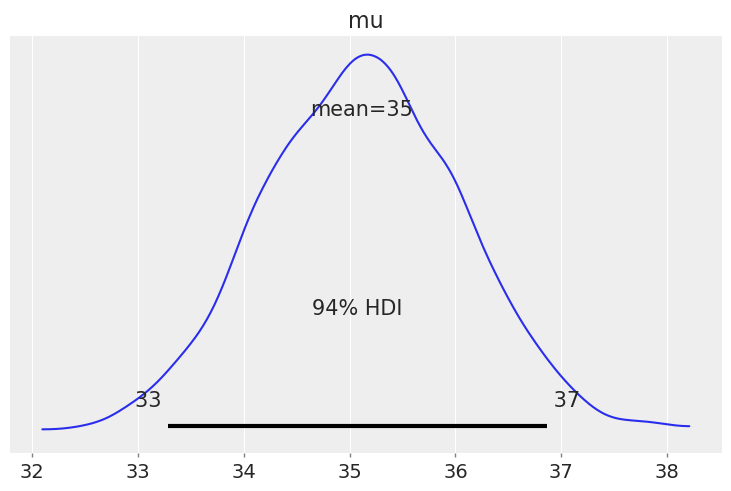

In [33]:
az.plot_posterior(idata)

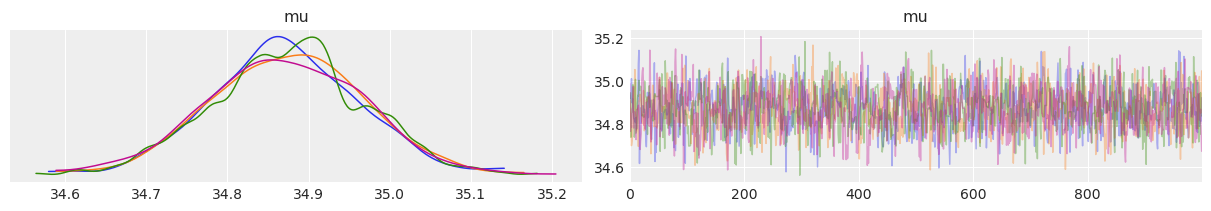

In [16]:
az.plot_trace(idata, compact = False);